# 1. Importer

## 1.1 Les modules nécessaire

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ExponentialLR, ReduceLROnPlateau, CosineAnnealingLR, LambdaLR
#from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import wandb
from preprocessing import DataPreprocessor
from analyse import DataAnalyzer
import os
os.environ["WANDB_NOTEBOOK_NAME"] = "TVAE.ipynb"
import time
from datetime import datetime, timedelta
import evaluation

import warnings
from typing import Dict, List, Tuple, Union
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
"""

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from typing import List, Union, Optional"""

GPU Name: NVIDIA GeForce RTX 3060 Laptop GPU
GPU Memory: 6.44 GB


'\n\nfrom sklearn.preprocessing import LabelEncoder, OneHotEncoder\nfrom sklearn.compose import ColumnTransformer\nfrom sklearn.impute import SimpleImputer\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nfrom scipy import stats\nfrom typing import List, Union, Optional'

In [4]:
%load_ext autoreload
%autoreload 2

## 1.2 Des données

In [109]:
data = pd.read_csv('data/DataModified.csv',sep= ',')
num = data.select_dtypes(np.number)
cat= data.select_dtypes(exclude=np.number)
data

,INPUT,DATA,CONFIG,T,EQUIPEMENT,DELTA,MESURE A,MESURE A REF,MESURE B,FREQUENCE,OUTPUT
0,"[-79.0, -78.26, -77.52, -76.78, -76.04, -75.3,...",0,0.0,11,1,144.0,-0.446507,-0.980103,3.214566,1,"[38.3674938, 39.34108554, 40.22793186, 41.0482..."
1,"[-79.0, -78.26, -77.52, -76.78, -76.04, -75.3,...",0,0.0,11,1,144.0,-0.446507,-0.980103,3.214566,1,"[38.3674938, 39.34108554, 40.22793186, 41.0482..."
2,"[-79.0, -78.26, -77.52, -76.78, -76.04, -75.3,...",0,0.0,11,1,144.0,-0.446507,-0.980103,3.214566,1,"[38.3674938, 39.34108554, 40.22793186, 41.0482..."
3,"[-79.0, -78.26, -77.52, -76.78, -76.04, -75.3,...",0,0.0,11,1,144.0,-0.446507,-0.980103,3.214566,1,"[38.3674938, 39.34108554, 40.22793186, 41.0482..."
4,"[-79.0, -78.26, -77.52, -76.78, -76.04, -75.3,...",0,0.0,11,1,144.0,-0.446507,-0.980103,3.214566,1,"[38.3674938, 39.34108554, 40.22793186, 41.0482..."
...,...,...,...,...,...,...,...,...,...,...,...
6840,"[-79.0, -78.26, -77.52, -76.78, -76.04, -75.3,...",87,-2.0,0,7,-23.0,-1.439788,-1.093460,1.229153,5,"[38.10072566, 39.0474599, 39.9193456, 40.72830..."
6841,"[-79.0, -78.26, -77.52, -76.78, -76.04, -75.3,...",64,-2.0,0,7,0.0,-1.093460,-1.093460,1.718189,5,"[37.18565224, 38.13745002, 39.003715, 39.81323..."
6842,"[-79.0, -78.26, -77.52, -76.78, -76.04, -75.3,...",0,0.5,0,7,40.0,-0.446849,-0.717651,2.108255,5,"[36.4964953, 37.42693808, 38.29379132, 39.1007..."
6843,"[-79.0, -78.26, -77.52, -76.78, -76.04, -75.3,...",20,0.5,0,7,20.0,-0.530118,-0.717651,1.665460,5,"[35.04453964, 35.97482844, 36.8397277, 37.6470..."


# 2. Preprocessing

In [85]:
    
# Create preprocessor
preprocessor = DataPreprocessor(
        categorical_features= cat.columns,
        numerical_features=num.columns,
        scaling_method='standard',
        categorical_encoding='onehot'
    )
    
    # Preprocess data
num = preprocessor.fill_num(num)
#preprocessed_data = preprocessor.fit_transform(data)
    
#print("\nOriginal data shape:", data.shape)
#print("Preprocessed data shape:", preprocessed_data.shape)
#print("\nFeature names:", preprocessor.feature_names_out_)
    
    # Inverse transform
#reconstructed_data = preprocessor.inverse_transform(preprocessed_data)
#print("\nReconstructed data sample:")
#print(reconstructed_data.head())

# 3. Visualiser des données initiales 

,DATA,CONFIG,T,EQUIPEMENT,DELTA,MESURE A,MESURE A REF,MESURE B,FREQUENCE
count,6845.000000,6845.000000,6845.000000,6845.000000,6845.000000,6845.000000,6845.000000,6845.000000,6845.000000
mean,91.869978,-0.386413,7.986121,3.462381,1.445581,-0.695638,-0.539388,2.623765,3.000000
std,64.076459,1.011725,5.506275,2.171139,33.623124,0.832821,0.543114,1.768035,1.414317
min,0.000000,-2.000000,0.000000,1.000000,-131.000000,-7.673330,-6.049308,-5.529413,1.000000
25%,44.000000,-2.000000,6.000000,1.000000,-2.000000,-0.913886,-0.817531,1.459265,2.000000
50%,86.000000,0.000000,6.000000,3.000000,0.000000,-0.593030,-0.711223,2.230435,3.000000
75%,130.000000,0.500000,11.000000,6.000000,0.000000,-0.068406,-0.121224,3.663460,4.000000
max,255.000000,0.500000,15.000000,7.000000,208.000000,0.000000,0.000000,11.580734,5.000000
skewness,0.444388,-0.870838,-0.216474,0.240445,1.533342,-3.513793,-5.225133,0.341602,0.000000
kurtosis,-0.346068,-1.034512,-1.288937,-1.428833,10.795778,20.259527,51.546328,2.050591,-1.300073


C:\Users\anhqu\anaconda3\envs\torchenv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6845.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\anhqu\anaconda3\envs\torchenv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6845.
  res = hypotest_fun_out(*samples, **kwds)


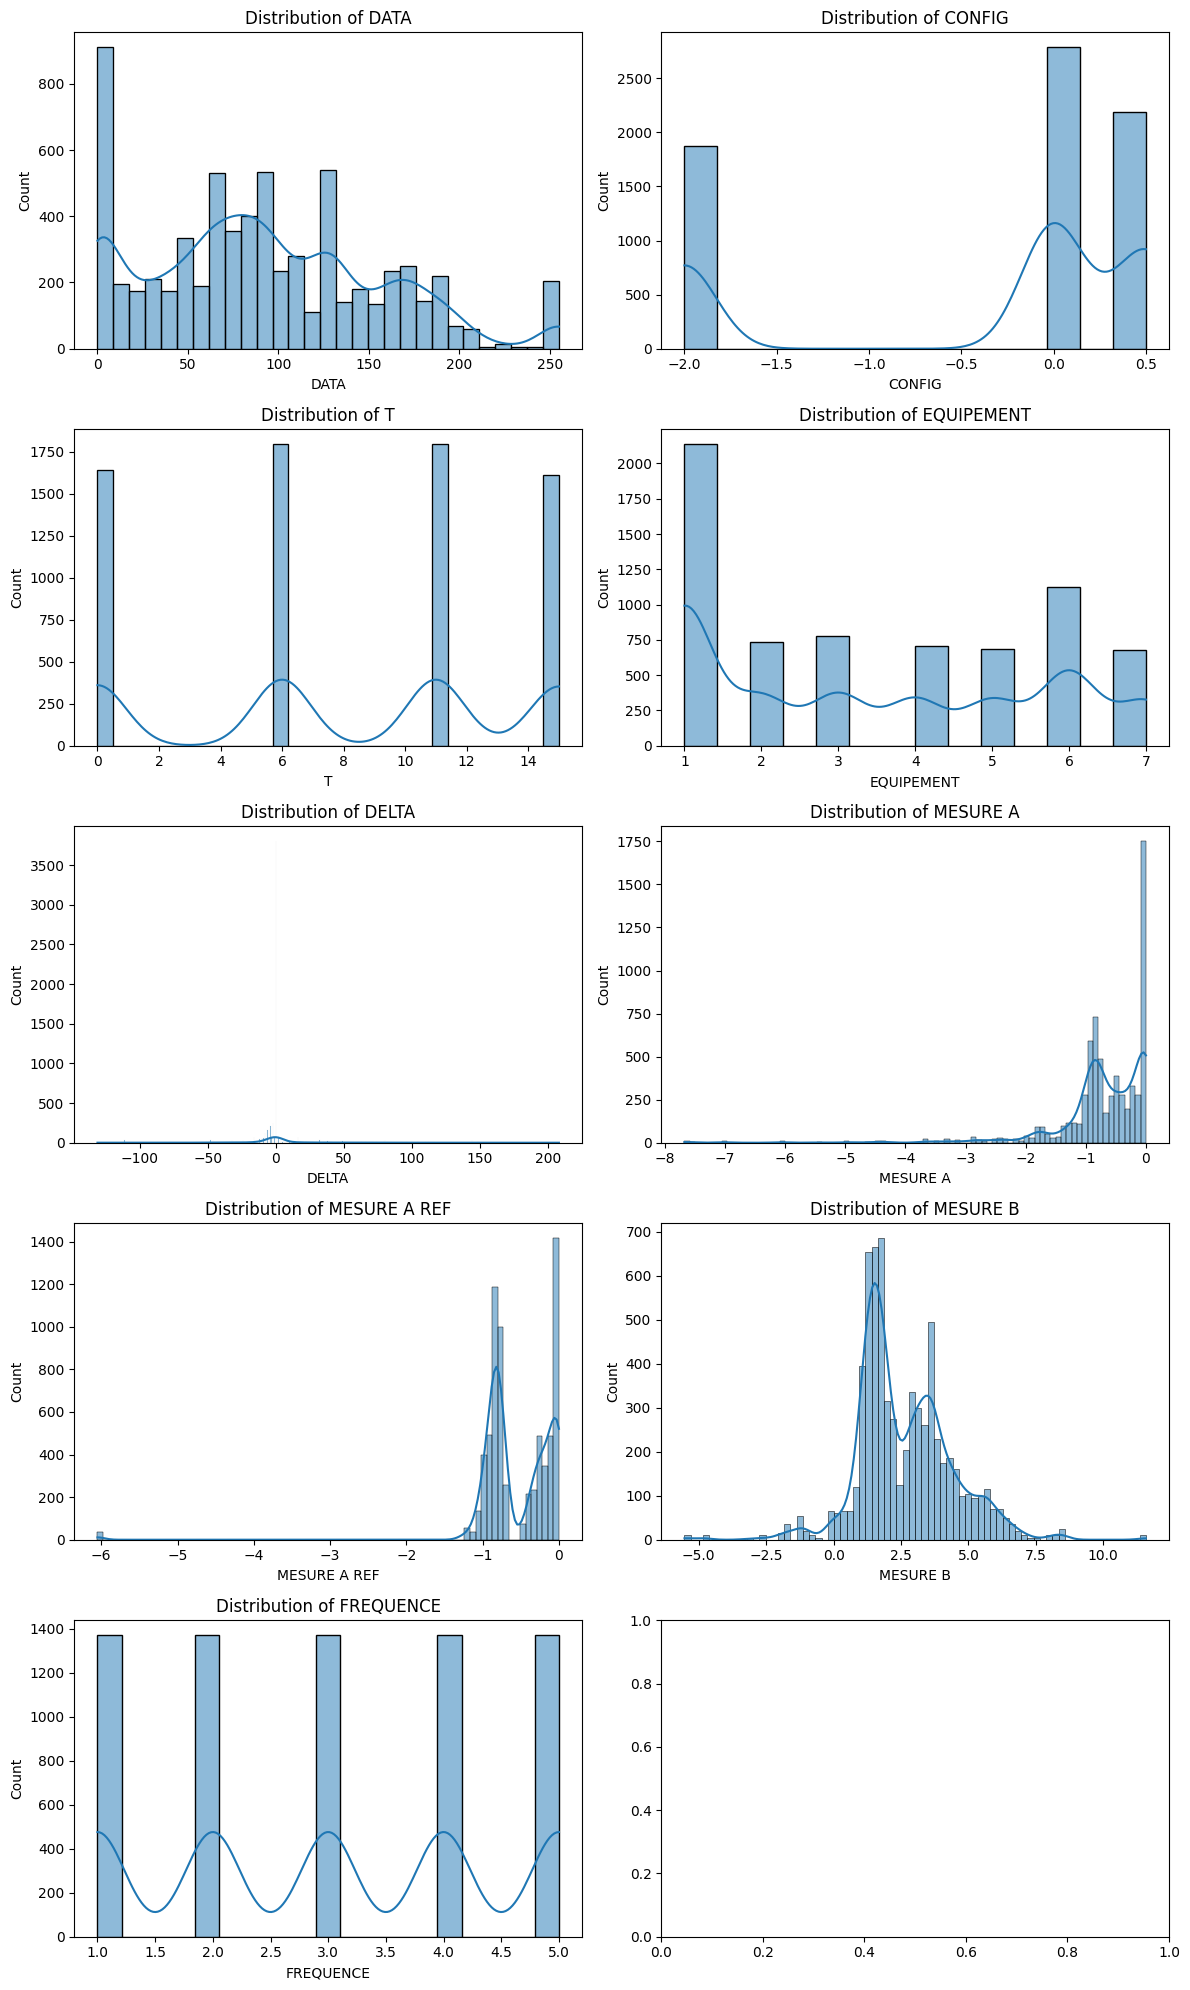

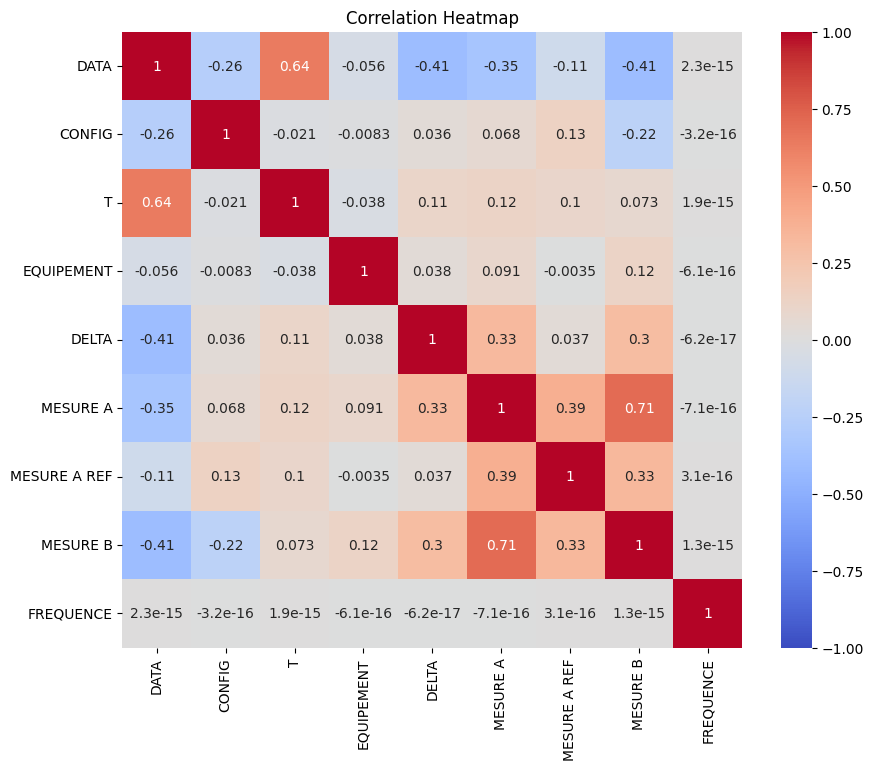

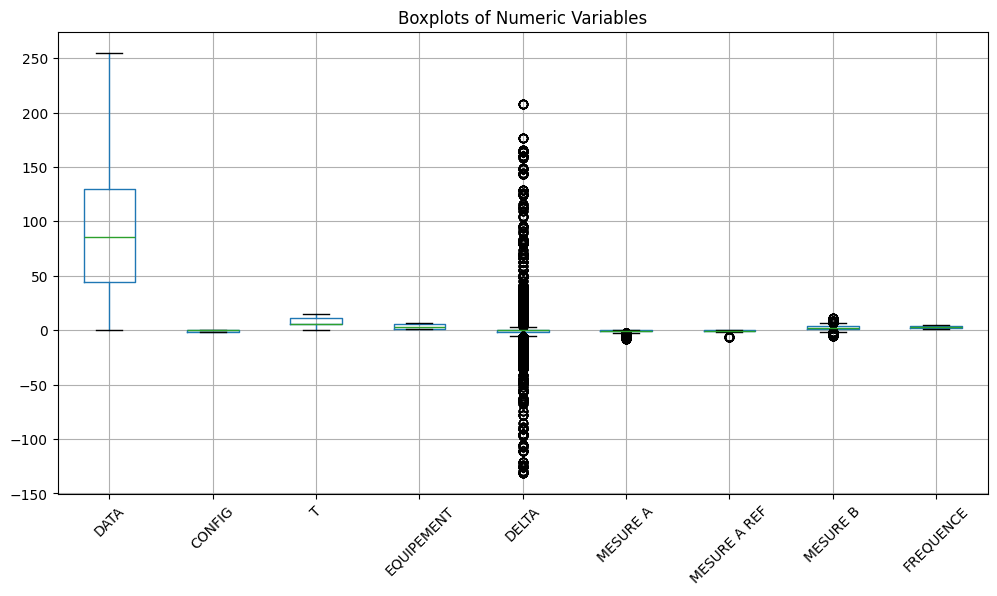

In [87]:
analyzer = DataAnalyzer(data)

# Get summary statistics
summary_stats = analyzer.get_summary_statistics()
display(summary_stats)
# Analyze distributions
distribution_analysis = analyzer.analyze_distributions()

# Create visualizations
analyzer.plot_distributions()
analyzer.plot_correlation_heatmap()
analyzer.plot_boxplots()

# Generate full report
report = analyzer.generate_report()

# 4. Générer des données 

## 4.1 TVAE

In [89]:
class TabularDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data,dtype=torch.float32)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

class TVAE(nn.Module):
    def __init__(self, input_dim, hidden_dims : list, latent_dim=32,use_batch_norm=True, dropout_rate = 0.2 , device = 'cpu'):
        super(TVAE, self).__init__()
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.dropout_rate = dropout_rate
        self.device = device
        # Encoder
        pre_dim = self.input_dim
        encoder_layers = []
        for dim in hidden_dims:
            encoder_layers.append(nn.Linear(pre_dim, dim))
            if use_batch_norm == True:
                encoder_layers.append(nn.BatchNorm1d(dim))
            encoder_layers.extend([nn.LeakyReLU(0.2),
                                   nn.Dropout(dropout_rate),
                                  ])
            pre_dim = dim
        self.encoder = nn.Sequential(*encoder_layers)
       
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1], latent_dim)
        
        # Decoder
        pre_dim = latent_dim
        decoder_layers = []
        for dim in reversed(hidden_dims):
            decoder_layers.append(nn.Linear(pre_dim, dim))
            if use_batch_norm == True:
                decoder_layers.append(nn.BatchNorm1d(dim))
            decoder_layers.extend([nn.LeakyReLU(0.2),
                                   nn.Dropout(dropout_rate),
                                  ])
            pre_dim = dim
        decoder_layers.extend([
            nn.Linear(hidden_dims[0], input_dim),
            nn.Tanh() 
        ])
        
        self.decoder = nn.Sequential(*decoder_layers)
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.fill_(0.01)
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_var(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std, device = self.device)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var
        
    def generate(self, n_samples):
        """Generate synthetic samples from random latent vectors"""
        with torch.no_grad():
            z = torch.randn(n_samples, self.latent_dim, device=self.device)
            return self.decode(z)
            
    def get_reconstruction_loss(self, x_recon, x, mu, log_var, beta=1.0):
        """
        Compute VAE loss with adjustable β-VAE formulation
        """
        # Reconstruction loss (MSE)
        recon_loss = F.mse_loss(x_recon, x, reduction='sum')
        #print(recon_loss.device)
        
        # KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Total loss with β weighting
        total_loss = recon_loss + beta * kl_loss
        
        return {
            'total_loss': total_loss,
            'reconstruction_loss': recon_loss,
            'kl_loss': kl_loss
        }
    
    def interpolate(self, x1, x2, steps=10):
        """Interpolate between two input samples in latent space"""
        with torch.no_grad():
            # Encode both inputs
            mu1, _ = self.encode(x1.unsqueeze(0))
            mu2, _ = self.encode(x2.unsqueeze(0))
            
            # Create interpolation points
            alphas = torch.linspace(0, 1, steps)
            interpolated = []
            
            # Generate intermediate points
            for alpha in alphas:
                z = mu1 * (1 - alpha) + mu2 * alpha
                interpolated.append(self.decode(z))
                
            return torch.cat(interpolated, dim=0)
            
    def compute_metrics(self, x, x_recon):
        """Compute quality metrics for generated samples"""
        with torch.no_grad():
            # Mean absolute error
            mae = F.l1_loss(x_recon, x, reduction='mean')
            
            # Mean squared error
            mse = F.mse_loss(x_recon, x, reduction='mean')
            
            # Cosine similarity
            cos_sim = F.cosine_similarity(x_recon, x).mean()
            
            return {
                'mae': mae.item(),
                'mse': mse.item(),
                'cosine_similarity': cos_sim.item()
            }

def train_tvae(model, train_loader, val_loader, num_epochs=100, learning_rate=1e-2):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    #scheduler = MultiStepLR(optimizer, milestones=[50,80], gamma=0.1)
    start_time = time.time()
    epoch_times = []
    wandb.init(
    # set the wandb project where this run will be logged
    project="Data Augmentation",
    name="tvae",
    # track hyperparameters and run metadata
    config={
    "learning_rate": learning_rate,
    "architecture": "TVAE",
    "dataset": "Physics",
    "epochs": num_epochs,
    }
)
    print(f"Training started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    for epoch in range(num_epochs):
        epoch_start = time.time()
        total_loss = 0
        model.train()
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            recon_batch, mu, log_var = model(batch)
            #print(model.device)
            # loss
            loss = model.get_reconstruction_loss(recon_batch,batch, mu, log_var )['total_loss']
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
        val_loss = compute_validation_loss(model, val_loader, device)
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        wandb.log({
                "learning_rate": current_lr,  # Track dynamic LR
                "train_loss": total_loss/len(train_loader.dataset),
                "val_loss" : val_loss,
                "epoch": epoch
            })   
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train loss: {total_loss/len(train_loader.dataset):.4f}, Val loss: {val_loss}, Learning Rate = {current_lr:.4f}')
            epoch_end = time.time()
            epoch_duration = epoch_end - epoch_start
            epoch_times.append(epoch_duration)
               
    print(f"Training finished at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    total_duration = time.time() - start_time
    print(f"Total training time: {format_time(total_duration)}")
    wandb.finish()
def generate_synthetic_data(model, n_samples, original_data):
    model.eval()
    with torch.no_grad():
        # Sample from latent space
        z = torch.randn(n_samples, model.fc_mu.out_features)
        # Generate synthetic data
        synthetic_data = model.decode(z)
    return synthetic_data.numpy()

def compute_validation_loss(model, val_loader, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0

    with torch.no_grad():  # Disable gradient computation
        for batch in val_loader:
            batch = batch.to(device)  # Move data to GPU/CPU
            recon_batch, mu, log_var = model(batch)  # Forward pass
            loss_dict = model.get_reconstruction_loss(
                recon_batch, batch, mu, log_var
            )
            total_loss += loss_dict['total_loss'].item()  # Sum losses

    # Average loss over the entire validation set
    avg_loss = total_loss / len(val_loader.dataset)
    return avg_loss

## 4.2. Entrainement 

In [93]:
def format_time(seconds):
    """Convert seconds to a human-readable format"""
    return str(timedelta(seconds=int(seconds)))
def train(save= True):
    # Create sample data
    original_data = num
    n_features =  num.shape[1]
    # Standardize the data
    scaler = StandardScaler()
    
    scaled_data = scaler.fit_transform(original_data)
    
    # Create dataset and dataloader
    dataset = TabularDataset(scaled_data)
    
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    
    
    # Initialize and train TVAE
    model = TVAE(input_dim=n_features,latent_dim = 8,hidden_dims=[64,64,32,32,16,16], device = device) 
    model = model.to(device)

    train_tvae(model, train_loader, val_loader,num_epochs=70, learning_rate=0.1)
    #model = model.to('cpu')
    
    is_saved = False
    if save:
        file_name = input("Tap model's name:" )
        while not is_saved:
            if os.path.exists(f"models/{file_name}.pth"):
                print("Model's name existes!!!!")
                file_name = input("Tap model's name:" )
            else:
                torch.save(model,f"models/{file_name}.pth")
                is_saved = True
                print("Done!!!!")
        return 1
train(save = True)


wandb: Currently logged in as: tuanhquanle (tuanhquanle-insa-toulouse) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Training started at: 2025-02-18 09:01:02
Epoch [10/70], Train loss: 9.2654, Val loss: 8.922881578510918, Learning Rate = 0.0500
Epoch [20/70], Train loss: 9.2432, Val loss: 9.073421001782636, Learning Rate = 0.0500
Epoch [30/70], Train loss: 9.1121, Val loss: 8.81888899653388, Learning Rate = 0.0250
Epoch [40/70], Train loss: 9.0795, Val loss: 8.774308922867256, Learning Rate = 0.0125
Epoch [50/70], Train loss: 9.0675, Val loss: 8.771577989732897, Learning Rate = 0.0031
Epoch [60/70], Train loss: 9.0602, Val loss: 8.773763919938995, Learning Rate = 0.0016
Epoch [70/70], Train loss: 9.0574, Val loss: 8.774524418431708, Learning Rate = 0.0004
Training finished at: 2025-02-18 09:03:48
Total training time: 0:02:48


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
learning_rate,███▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅█▂▂▂▃▂▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▃▂▃█▁▁▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,69
learning_rate,0.00039
train_loss,9.05741
val_loss,8.77452


Tap model's name: test01


Done!!!!


1

### 4.3 Generation des données

In [99]:
n_samples = 100

In [101]:
model_name = "test01"


original_data = num
n_features =  num.shape[1]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(original_data)

model = torch.load(f"models/{model_name}.pth", weights_only=False)
model = model.to('cpu')

synthetic_data = generate_synthetic_data(model, n_samples, original_data) 
    # Inverse transform the synthetic data
synthetic_data_original_scale = scaler.inverse_transform(synthetic_data)

    # Convert to DataFrame
synthetic_df = pd.DataFrame(
synthetic_data_original_scale,
columns=[f'feature_{i+1}' for i in range(n_features)])
print("\nSynthetic Data Sample:")
print(synthetic_df.head())
print("\nSynthetic Data Statistics:")
print(synthetic_df.describe())


Synthetic Data Sample:
   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0  91.404297  -0.387563   7.902424   3.444263   1.541527  -0.703303   
1  91.401505  -0.387734   7.901905   3.444898   1.549008  -0.703299   
2  91.404327  -0.387525   7.902550   3.444130   1.540523  -0.703294   
3  91.403664  -0.387523   7.902535   3.444141   1.540985  -0.703288   
4  91.404724  -0.387516   7.902574   3.444106   1.540128  -0.703298   

   feature_7  feature_8  feature_9  
0  -0.543747   2.610060   2.999481  
1  -0.543761   2.610275   2.999601  
2  -0.543744   2.610026   2.999453  
3  -0.543742   2.610039   2.999450  
4  -0.543745   2.610011   2.999449  

Synthetic Data Statistics:
        feature_1   feature_2   feature_3   feature_4   feature_5   feature_6  \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean    91.406982   -0.388039    7.901161    3.445556    1.554798   -0.703367   
std      0.023597    0.002901    0.007655    0.007558   

### 4.4 Evaluation


In [103]:
 # Créer l'évaluateur
evaluateur = evaluation.EvaluateurDonneesSynthetiques(original_data, synthetic_df)
    
    # Obtenir le rapport complet
evaluateur.statistiques_basiques()

,DATA_original,DATA_synthetique,CONFIG_original,CONFIG_synthetique,T_original,T_synthetique,EQUIPEMENT_original,EQUIPEMENT_synthetique,DELTA_original,DELTA_synthetique,MESURE A_original,MESURE A_synthetique,MESURE A REF_original,MESURE A REF_synthetique,MESURE B_original,MESURE B_synthetique,FREQUENCE_original,FREQUENCE_synthetique
moyenne,91.869978,91.406975,-0.386413,-0.388039,7.986121,7.901162,3.462381,3.445556,1.445581,1.554798,-0.695638,-7.033671e-01,-0.539388,-5.437933e-01,2.623765,2.610429,3.0,2.999814
variance,4105.192736,0.000551,1.023438,0.000008,30.314636,0.000058,4.713158,0.000057,1130.349303,0.005206,0.693489,2.279156e-07,0.294929,7.519268e-08,3.125490,0.000004,2.0,0.000004
max,255.000000,91.601967,0.500000,-0.387490,15.000000,7.902655,7.000000,3.506808,208.000000,2.138342,0.000000,-7.032877e-01,0.000000,-5.437421e-01,11.580734,2.626959,5.0,3.016254
min,0.000000,91.400475,-2.000000,-0.411605,0.000000,7.838925,1.000000,3.444019,-131.000000,1.539415,-7.673330,-7.073336e-01,-6.049308,-5.460111e-01,-5.529413,2.609985,1.0,2.999433


In [230]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

18132

In [240]:
a = [[1,2],[3,4]]
print(a)
print(np.max(a, axis=1))

[[1, 2], [3, 4]]
[2 4]


In [302]:
os.path.isfile(f"models/tvae01")

False